In [1]:
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools
from random import shuffle, random, randint
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA, ProbabilisticPCA, KernelPCA, MiniBatchSparsePCA, SparsePCA
from sklearn.svm import LinearSVC, SVC, LinearSVC, SVR, NuSVR
%matplotlib inline

In [2]:
def HaversineDistance(c1, c2): 
  lon_diff = np.abs(c1[0]-c2[0])*np.pi/360.0
  lat_diff = np.abs(c1[1]-c2[1])*np.pi/360.0
  a = np.sin(lat_diff)**2 + np.cos(c1[1]*np.pi/180.0) * np.cos(c2[1]*np.pi/180.0) * np.sin(lon_diff)**2
  d = 2*6371*np.arctan2(np.sqrt(a), np.sqrt(1-a))
  return d

def EuclidDistance(c1, c2):
    return np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)


def load_data(num_records_to_load=10):
    submission_df = pd.read_csv('/home/tony/ML/taxi/taxi2_time/test.csv')
    submission_df['POLYLINE'] = submission_df['POLYLINE'].apply(json.loads)
    submission_df['COORDS_LEN'] = submission_df['POLYLINE'].apply(len)
    submission_df['START'] = submission_df['POLYLINE'].apply(lambda x: x[0])

    # read train
    taxi_df = pd.read_csv('/home/tony/ML/taxi/taxi2_time/train.csv', nrows=num_records_to_load)
    taxi_df['POLYLINE'] = taxi_df['POLYLINE'].apply(json.loads)
    taxi_df['COORDS_LEN'] = taxi_df['POLYLINE'].apply(len)
    taxi_df = taxi_df[taxi_df.COORDS_LEN > 10]
    taxi_df['START'] = taxi_df['POLYLINE'].apply(lambda x: x[0])
    taxi_df['END'] = taxi_df['POLYLINE'].apply(lambda x: x[-1])
    
    return taxi_df, submission_df


def createTrainTestSplit(df, percent_test=0.1):
    num_rows = len(df)
    num_train = num_rows - int(num_rows*percent_test)
    mask = np.random.rand(num_rows) > percent_test
    
    train_df, test_df = df[mask], df[~mask]
    train_time, test_time = 15*train_df['COORDS_LEN'].values, 15*test_df['COORDS_LEN'].values
    train_end, test_end = train_df['END'].values, test_df['END'].values

    # Save reference to complete path for analytical purposes
    test_df['POLYLINE_ACTUAL'] = test_df['POLYLINE'].values[:]
    
    #Create partial paths for the test data
    #coords = test_df['POLYLINE'].values[:]
    #partial_lengths = [round(0.5*len(coord)) for coord in coords]
    #test_df['POLYLINE'] = [coords[:n] for n in partial_lengths]
    test_df['POLYLINE'] = [coord[:int(round(0.5*len(coord)))] for coord in test_df['POLYLINE'].values]
    
    
    #Drop all data that we shouldn't have during training
    test_df = test_df.drop(['COORDS_LEN', 'END'], axis=1)
    test_df['COORDS_LEN'] = test_df['POLYLINE'].apply(len)
    
    return train_df, test_df, train_time, test_time, train_end, test_end

def travelTimeScore(pred_times, actual_times):
    score = np.sqrt(np.mean((np.log(pred_times+1)-np.log(actual_times+1))**2))
    return score

def travelEndScore(pred_ends, actual_ends):
    num_points = len(pred_ends)
    preds, actuals = pred_ends, actual_ends
    score = np.mean([HaversineDistance(preds[i], actuals[i]) for i in range(num_points)])
    return score
    
def submitTravelTime(validation_df, filename):
    validation_df[['TRIP_ID', 'TRAVEL_TIME']].to_csv(filename, index=False)
    
def submitTravelDestination(validation_df, filename):
    validation_df['LATITUDE'] = validation_df['TRAVEL_END'].apply(lambda x: x[1])
    validation_df['LONGITUDE'] = validation_df['TRAVEL_END'].apply(lambda x: x[0])
    validation_df[['TRIP_ID', 'LATITUDE', 'LONGITUDE']].to_csv(filename, index=False)
    
def randColor():
    r = lambda: randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))

In [3]:
num_records = 20000
test_size = 200

taxi_df, submission_df = load_data(num_records_to_load=num_records)
train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))


/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


num_records: 1000 num_centers: 20 final score: 3.2092786939
num_records: 1000 num_centers: 60 final score: 3.34216874
num_records: 1000 num_centers: 100 final score: 3.4502827394
num_records: 1000 num_centers: 200 final score: 3.31599178747


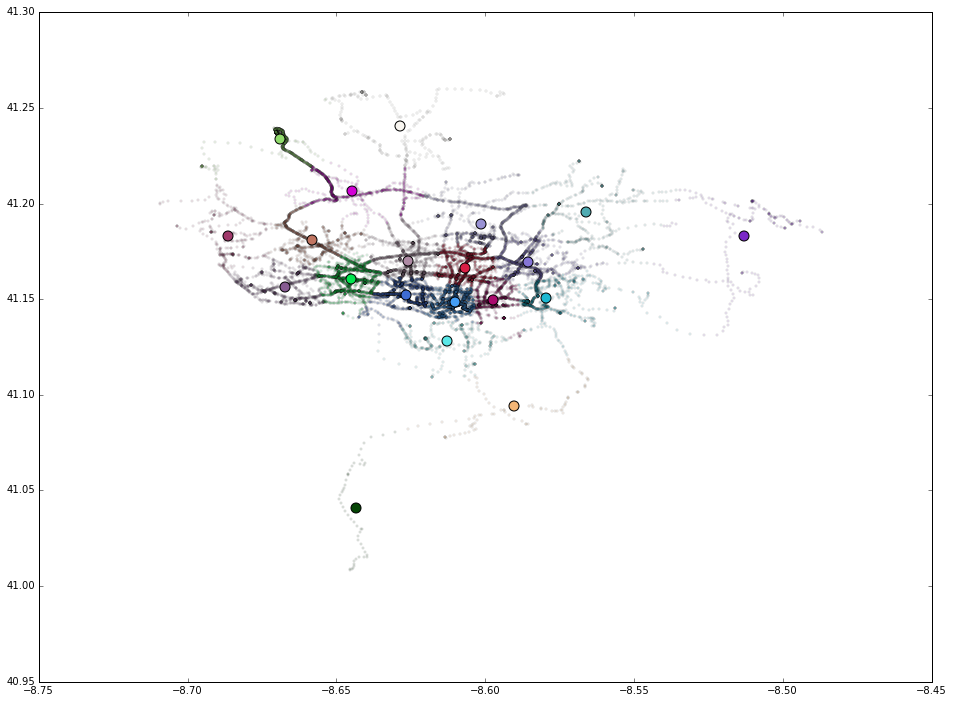

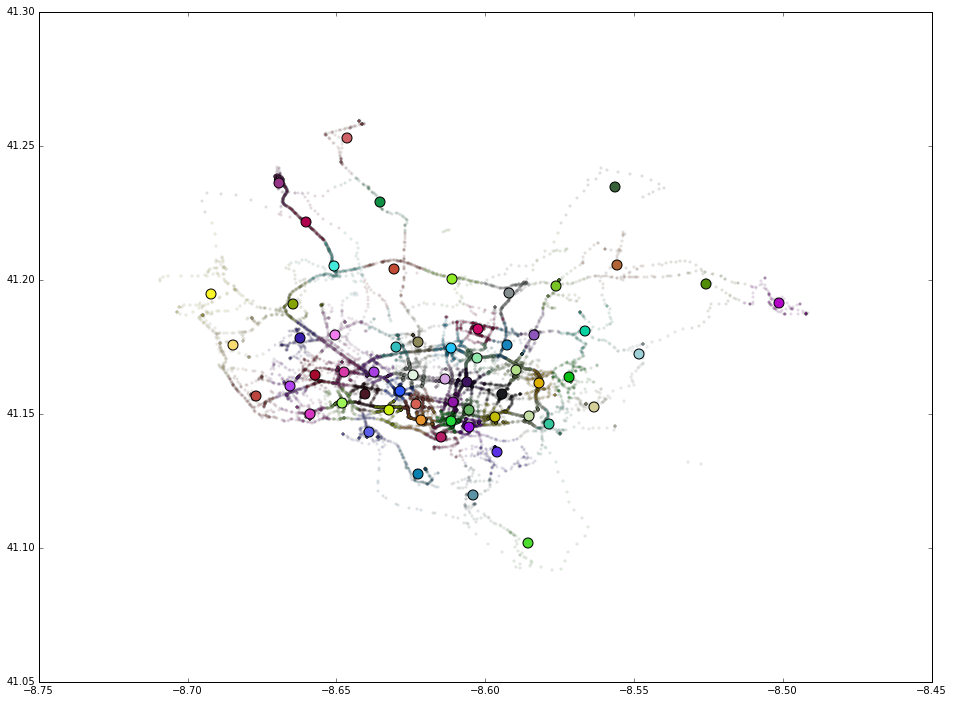

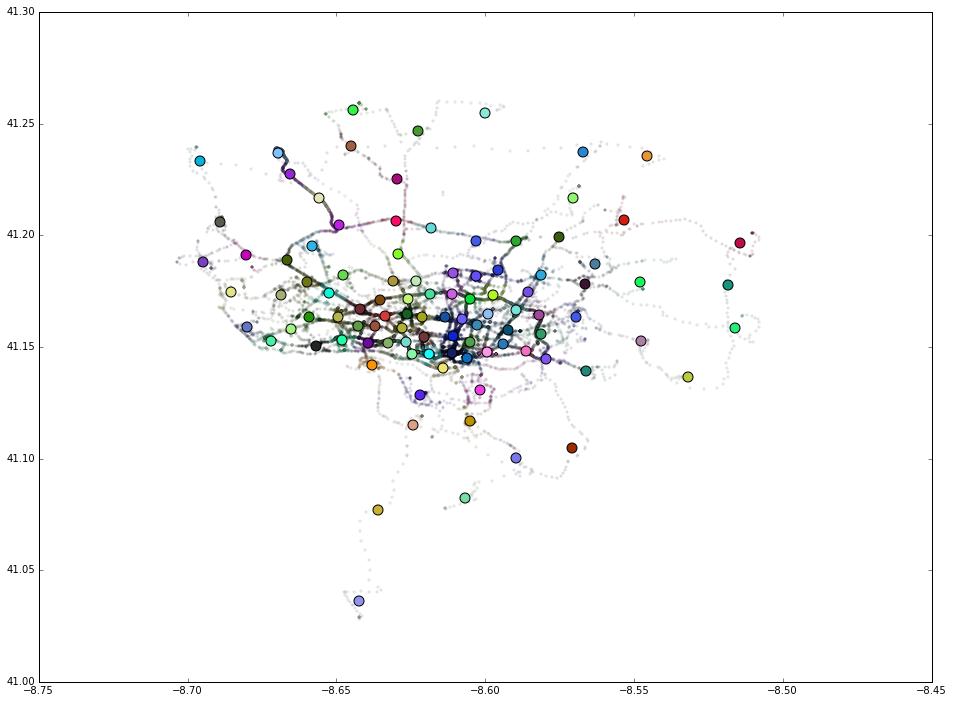

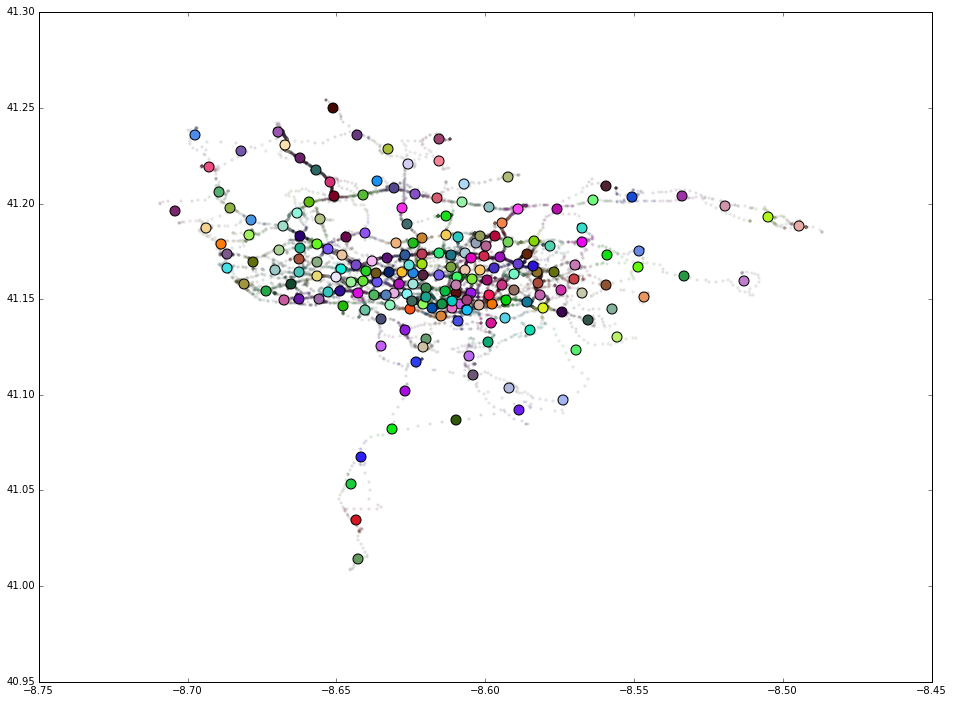

In [7]:
def path_to_policy(seq):
    return [k for k, g in itertools.groupby(seq)]

def clusterData(train_paths, num_clusters = 100, plot_it=True):
    all_coords = np.array([c for path in train_paths for c in path])
    kmeans = KMeans(n_clusters=num_clusters, n_jobs=6)
    kmeans.fit(all_coords)
    cluster_centers = kmeans.cluster_centers_
    train_grid = [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in train_paths]


    if plot_it:
        plt.figure(figsize=(16, 12))
        all_coords_grid_weights = kmeans.transform(all_coords)
        cluster_indexes = np.array([np.argmin(x) for x in all_coords_grid_weights])
        cluster_centers = kmeans.cluster_centers_
        for k in range(num_clusters):
            color=randColor()
            plt.scatter(all_coords[:,0][cluster_indexes == k], all_coords[:,1][cluster_indexes == k], s=5, c=color, alpha=0.1)
            plt.scatter(cluster_centers[k][0], cluster_centers[k][1], s=100, c=color)

    return kmeans, train_grid, num_clusters, cluster_centers

def getGridPaths(kmeans, paths):
    return [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in paths]

def getGridMatrix(grid_paths, k):
    return np.array([[1 if n in grid_path else 0 for n in range(k)] for grid_path in grid_paths])

def clusterIndexesToPoints(grid_y, cluster_centers):
    return [cluster_centers[k] for k in grid_y]


def do_predict(num_records, num_centers, test_size):
    taxi_df, submission_df = load_data(num_records_to_load=num_records)
    train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))

    #print "getting clusters"
    kmeans, train_grid_paths, k, cluster_centers = clusterData(train_df['POLYLINE'].values, num_centers, True)
    #print "generating policies"
    test_grid_paths = getGridPaths(kmeans, test_df['POLYLINE'].values)
    test_grid_actual_paths = getGridPaths(kmeans, test_df['POLYLINE_ACTUAL'])

    train_grid_y = [x[-1] for x in train_grid_paths]
    test_grid_y = [x[-1] for x in test_grid_actual_paths]
    train_grid = getGridMatrix(train_grid_paths, k)
    test_grid = getGridMatrix(test_grid_paths, k)

    #print "training classifier"
    svc = RandomForestClassifier()
    svc.fit(train_grid, train_grid_y)
    y_pred = svc.predict(test_grid)
    #print "percent clusters right:", np.mean(y_pred == test_grid_y)

    y_pred_coords = clusterIndexesToPoints(y_pred, cluster_centers)
    score = travelEndScore(y_pred_coords, test_end)
    print "num_records:", num_records, "num_centers:", num_centers, "final score:", score

    #creating submission
    #print "creating submisison paths"
    submission_grid_paths = getGridPaths(kmeans, submission_df['POLYLINE'])
    submission_grid = getGridMatrix(submission_grid_paths, k)
    #print "predicting on submission"
    y_sub = svc.predict(submission_grid)
    y_sub_coords = clusterIndexesToPoints(y_sub, cluster_centers)
    #print "saving to file"
    submission_df['TRAVEL_END'] = y_sub_coords
    submitTravelDestination(submission_df, "sub_END_kmeans_svc_cntr%d_pts%d_%d.csv" % (num_records, num_centers, score*100))
    

test_size = 500

for num_records in [1000]:
    for num_centers in [20, 60, 100, 200]:
        do_predict(num_records, num_centers, test_size)


In [170]:
print "training classifier"
svc = SVC()
svc.fit(train_grid, train_grid_y)
y_pred = svc.predict(test_grid)
print "percent clusters right:", np.mean(y_pred == test_grid_y)

y_pred_coords = clusterIndexesToPoints(y_pred, cluster_centers)
print "final score:", travelEndScore(y_pred_coords, test_end)

training classifier
percent clusters right: 0.258823529412
final score: 4.31931793408


In [174]:
print "creating submisison paths"
submission_grid_paths = getGridPaths(kmeans, submission_df['POLYLINE'])
submission_grid = getGridMatrix(submission_grid_paths, k)
print "predicting on submission"
y_sub = svc.predict(submission_grid)
y_sub_coords = clusterIndexesToPoints(y_sub, cluster_centers)
print "saving to file"
submission_df['TRAVEL_END'] = y_sub_coords
submitTravelDestination(submission_df, "sub_END_kmeans_svc_200points_277.csv")

creating submisison paths
predicting on submission
saving to file


In [206]:
class PolicyClassifier:
    def __init__(self):
        pass
    
    def fit(self, train_paths, num_clusters=100):
        self._all_coords = np.array([c for path in train_paths for c in path])
        self._num_clusters = num_clusters
        self._kmeans = KMeans(n_clusters=num_clusters, n_jobs=4)
        self._kmeans.fit(self._all_coords)
        self._train_grid_paths = getGridPaths(self._kmeans, train_paths)
        self._train_grid = getGridMatrix(self._train_grid_paths, k)
        self._train_grid_y = [x[-1] for x in self._train_grid_paths]
    
    def transform(self, paths):
        return getGridPaths(self._kmeans, paths)
    
    def predict(self, test_paths):
        test_grid_paths = getGridPaths(self._kmeans, test_paths)
        test_grid = getGridMatrix(test_grid_paths, k)
        
        svc = SVC()
        svc.fit(self._train_grid, self._train_grid_y)
        y_pred = svc.predict(test_grid)
        y_pred_coords = clusterIndexesToPoints(y_pred, cluster_centers)
        
        return y_pred_coords
    
    
    
    
    
    def getGridPaths(self, kmeans, paths):
        return [path_to_policy([np.argmin(ln) for ln in self._kmeans.transform(path)]) for path in paths]

    def getGridMatrix(self, grid_paths, k):
        return np.array([[1 if n in grid_path else 0 for n in range(k)] for grid_path in grid_paths])

    def clusterIndexesToPoints(self, grid_y, cluster_centers):
        return [cluster_centers[k] for k in grid_y]
    
    def plot(self):
        plt.figure(figsize=(16, 12))
        all_coords_grid_weights = self._kmeans.transform(self._all_coords)
        cluster_indexes = np.array([np.argmin(x) for x in all_coords_grid_weights])
        for k in range(self._num_clusters):
            color=randColor()
            plt.scatter(self._all_coords[:,0][cluster_indexes == k], self._all_coords[:,1][cluster_indexes == k], s=5, c=color, alpha=0.1)
            plt.scatter(self._kmeans._cluster_centers[k][0], self._kmeans._cluster_centers[k][1], s=100, c=color)


In [ ]:
# Copied code from above that only considers center points

def path_to_policy(seq):
    return [k for k, g in itertools.groupby(seq)]

def clusterData(train_paths, num_clusters = 100, plot_it=True):
    all_coords = np.array([c for path in train_paths for c in path])
    kmeans = KMeans(n_clusters=num_clusters, n_jobs=6)
    kmeans.fit(all_coords)
    cluster_centers = kmeans.cluster_centers_
    train_grid = [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in train_paths]


    if plot_it:
        plt.figure(figsize=(16, 12))
        all_coords_grid_weights = kmeans.transform(all_coords)
        cluster_indexes = np.array([np.argmin(x) for x in all_coords_grid_weights])
        cluster_centers = kmeans.cluster_centers_
        for k in range(num_clusters):
            color=randColor()
            plt.scatter(all_coords[:,0][cluster_indexes == k], all_coords[:,1][cluster_indexes == k], s=5, c=color, alpha=0.1)
            plt.scatter(cluster_centers[k][0], cluster_centers[k][1], s=100, c=color)

    return kmeans, train_grid, num_clusters, cluster_centers

def getGridPaths(kmeans, paths):
    return [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in paths]

def getGridMatrix(grid_paths, k):
    return np.array([[1 if n in grid_path else 0 for n in range(k)] for grid_path in grid_paths])

def clusterIndexesToPoints(grid_y, cluster_centers):
    return [cluster_centers[k] for k in grid_y]

def getDeltaMatrix(grid_paths, k):
    m = np.zeros((len(grid_paths), k, k))
    for i, path in zip(range(len(grid_paths)), grid_paths):
        points_per_path = len(path)
        if points_per_path <= 1:
            continue
        for j in range(points_per_path-1):
            m[i,path[j-1],path[j]] = 1
            
    return m.reshape((m.shape[0], k*k))


def do_predict(num_records, num_centers, test_size):
    taxi_df, submission_df = load_data(num_records_to_load=num_records)
    train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))

    #print "getting clusters"
    kmeans, train_grid_paths, k, cluster_centers = clusterData(train_df['POLYLINE'].values, num_centers, False)
    #print "generating policies"
    test_grid_paths = getGridPaths(kmeans, test_df['POLYLINE'].values)
    test_grid_actual_paths = getGridPaths(kmeans, test_df['POLYLINE_ACTUAL'])

    train_grid_y = [x[-1] for x in train_grid_paths]
    test_grid_y = [x[-1] for x in test_grid_actual_paths]
    train_grid = getDeltaMatrix(train_grid_paths, k)
    test_grid = getDeltaMatrix(test_grid_paths, k)

    #print "training classifier"
    svc = RandomForestClassifier()
    svc.fit(train_grid, train_grid_y)
    y_pred = svc.predict(test_grid)
    #print "percent clusters right:", np.mean(y_pred == test_grid_y)

    y_pred_coords = clusterIndexesToPoints(y_pred, cluster_centers)
    score = travelEndScore(y_pred_coords, test_end)
    print "num_records:", num_records, "num_centers:", num_centers, "final score:", score

    #creating submission
    #print "creating submisison paths"
    submission_grid_paths = getGridPaths(kmeans, submission_df['POLYLINE'])
    submission_grid = getDeltaMatrix(submission_grid_paths, k)
    #print "predicting on submission"
    y_sub = svc.predict(submission_grid)
    y_sub_coords = clusterIndexesToPoints(y_sub, cluster_centers)
    #print "saving to file"
    submission_df['TRAVEL_END'] = y_sub_coords
    submitTravelDestination(submission_df, "sub_END_delta_svc_cntr%d_pts%d_%d.csv" % (num_records, num_centers, score*100))
    

test_size = 1000

for num_records in [100000]:
    for num_centers in [100, 120, 140, 160]:
        do_predict(num_records, num_centers, test_size)

/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


In [ ]:
# Copied code from above that only considers center points

def path_to_policy(seq):
    return [k for k, g in itertools.groupby(seq)]

def clusterData(train_paths, num_clusters = 100, plot_it=True):
    all_coords = np.array([c for path in train_paths for c in path])
    kmeans = KMeans(n_clusters=num_clusters, n_jobs=6)
    kmeans.fit(all_coords)
    cluster_centers = kmeans.cluster_centers_
    train_grid = [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in train_paths]


    if plot_it:
        plt.figure(figsize=(16, 12))
        all_coords_grid_weights = kmeans.transform(all_coords)
        cluster_indexes = np.array([np.argmin(x) for x in all_coords_grid_weights])
        cluster_centers = kmeans.cluster_centers_
        for k in range(num_clusters):
            color=randColor()
            plt.scatter(all_coords[:,0][cluster_indexes == k], all_coords[:,1][cluster_indexes == k], s=5, c=color, alpha=0.1)
            plt.scatter(cluster_centers[k][0], cluster_centers[k][1], s=100, c=color)

    return kmeans, train_grid, num_clusters, cluster_centers

def getGridPaths(kmeans, paths):
    return [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in paths]

def getGridMatrix(grid_paths, k):
    return np.array([[1 if n in grid_path else 0 for n in range(k)] for grid_path in grid_paths])

def clusterIndexesToPoints(grid_y, cluster_centers):
    return [cluster_centers[k] for k in grid_y]

def getDeltaMatrix(grid_paths, k):
    m = np.zeros((len(grid_paths), k, k))
    for i, path in zip(range(len(grid_paths)), grid_paths):
        points_per_path = len(path)
        if points_per_path <= 1:
            continue
        for j in range(points_per_path-1):
            m[i,path[j-1],path[j]] = 1
            
    return m.reshape((m.shape[0], k*k))

#TODO:
#row = np.array([0, 0, 1, 2, 2, 2])
#col = np.array([0, 2, 2, 0, 1, 2])
#data = np.array([1, 2, 3, 4, 5, 6])
#csr_matrix((data, (row, col)), shape=(3, 3)).toarray()
def getSparseDeltaMatrix(grid_paths, k):
    m = []
    for i, path in zip(range(len(grid_paths)), grid_paths):
        points_per_path = len(path)
        if points_per_path <= 1:
            continue
        for j in range(points_per_path-1):
            m.append((1, i, path[j-1]*k + path[j]))
    
    data, rows, cols = zip(*m)        
    return csr_matrix((data, (rows, cols)), shape=(k,k))


def do_predict(num_records, num_centers, test_size):
    taxi_df, submission_df = load_data(num_records_to_load=num_records)
    train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))

    #print "getting clusters"
    kmeans, train_grid_paths, k, cluster_centers = clusterData(train_df['POLYLINE'].values, num_centers, False)
    #print "generating policies"
    test_grid_paths = getGridPaths(kmeans, test_df['POLYLINE'].values)
    test_grid_actual_paths = getGridPaths(kmeans, test_df['POLYLINE_ACTUAL'])

    train_grid_y = [x[-1] for x in train_grid_paths]
    test_grid_y = [x[-1] for x in test_grid_actual_paths]
    train_grid = getSparseDeltaMatrix(train_grid_paths, k)
    test_grid = getSparseDeltaMatrix(test_grid_paths, k)

    #print "training classifier"
    svc = RandomForestClassifier()
    svc.fit(train_grid, train_grid_y)
    y_pred = svc.predict(test_grid)
    #print "percent clusters right:", np.mean(y_pred == test_grid_y)

    y_pred_coords = clusterIndexesToPoints(y_pred, cluster_centers)
    score = travelEndScore(y_pred_coords, test_end)
    print "num_records:", num_records, "num_centers:", num_centers, "final score:", score

    #creating submission
    #print "creating submisison paths"
    submission_grid_paths = getGridPaths(kmeans, submission_df['POLYLINE'])
    submission_grid = getSparseDeltaMatrix(submission_grid_paths, k)
    #print "predicting on submission"
    y_sub = svc.predict(submission_grid)
    y_sub_coords = clusterIndexesToPoints(y_sub, cluster_centers)
    #print "saving to file"
    submission_df['TRAVEL_END'] = y_sub_coords
    submitTravelDestination(submission_df, "sub_END_delta_svc_cntr%d_pts%d_%d.csv" % (num_records, num_centers, score*100))
    

test_size = 100

for num_records in [1000]:
    for num_centers in [10]:
        do_predict(num_records, num_centers, test_size)

In [231]:
def getDeltaMatrix(grid_paths, k):
    m = np.zeros((len(grid_paths), k, k))
    for i, path in zip(range(len(grid_paths)), grid_paths):
        points_per_path = len(path)
        if points_per_path <= 1:
            continue
        for j in range(points_per_path-1):
            m[i,path[j-1],path[j]] = 1
            
    return m.reshape((m.shape[0], k*k))

test_delta = getDeltaMatrix(test_grid_paths, k)
test_delta.shape

(123, 100)

In [ ]:
# Copied code from above that only considers center points

def path_to_policy(seq):
    return [k for k, g in itertools.groupby(seq)]

def clusterData(train_paths, num_clusters = 100, plot_it=True):
    all_coords = np.array([c for path in train_paths for c in path])
    kmeans = KMeans(n_clusters=num_clusters, n_jobs=6)
    kmeans.fit(all_coords)
    cluster_centers = kmeans.cluster_centers_
    train_grid = [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in train_paths]


    if plot_it:
        plt.figure(figsize=(16, 12))
        all_coords_grid_weights = kmeans.transform(all_coords)
        cluster_indexes = np.array([np.argmin(x) for x in all_coords_grid_weights])
        cluster_centers = kmeans.cluster_centers_
        for k in range(num_clusters):
            color=randColor()
            plt.scatter(all_coords[:,0][cluster_indexes == k], all_coords[:,1][cluster_indexes == k], s=5, c=color, alpha=0.1)
            plt.scatter(cluster_centers[k][0], cluster_centers[k][1], s=100, c=color)

    return kmeans, train_grid, num_clusters, cluster_centers

def getGridPaths(kmeans, paths):
    return [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in paths]

def getGridMatrix(grid_paths, k):
    return np.array([[1 if n in grid_path else 0 for n in range(k)] for grid_path in grid_paths])

def clusterIndexesToPoints(grid_y, cluster_centers):
    return [cluster_centers[k] for k in grid_y]

def getDeltaMatrix(grid_paths, k):
    m = np.zeros((len(grid_paths), k, k))
    for i, path in zip(range(len(grid_paths)), grid_paths):
        points_per_path = len(path)
        if points_per_path <= 1:
            continue
        for j in range(points_per_path-1):
            m[i,path[j-1],path[j]] = 1
            
    return m.reshape((m.shape[0], k*k))


def do_predict(num_records, num_centers, test_size):
    taxi_df, submission_df = load_data(num_records_to_load=num_records)
    train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))

    #print "getting clusters"
    kmeans, train_grid_paths, k, cluster_centers = clusterData(train_df['POLYLINE'].values, num_centers, False)
    #print "generating policies"
    test_grid_paths = getGridPaths(kmeans, test_df['POLYLINE'].values)
    test_grid_actual_paths = getGridPaths(kmeans, test_df['POLYLINE_ACTUAL'])

    train_grid_y = [x[-1] for x in train_grid_paths]
    test_grid_y = [x[-1] for x in test_grid_actual_paths]
    
    train_grid1 = getDeltaMatrix(train_grid_paths, k)
    test_grid1 = getDeltaMatrix(test_grid_paths, k)
    
    pca = PCA()
    pca.fit(train_grid1)
    train_grid = pca.transform(train_grid1)
    test_grid = pca.transform(test_grid1)

    #print "training classifier"
    svc = RandomForestRegressor()
    svc.fit(train_grid, train_time)
    y_pred = svc.predict(test_grid)
    score = travelTimeScore(y_pred, test_time)
    print "num_records:", num_records, "num_centers:", num_centers, "final score:", score

    #creating submission
    #print "creating submisison paths"
    submission_grid_paths = getGridPaths(kmeans, submission_df['POLYLINE'])
    submission_grid1 = getDeltaMatrix(submission_grid_paths, k)
    submission_grid = pca.transform(submission_grid1)
    #print "predicting on submission"
    y_sub = svc.predict(submission_grid)
    submission_df['TRAVEL_TIME'] = y_sub
    submitTravelTime(submission_df, "sub_TIME_delta_rf_cntr%d_pts%d_%d.csv" % (num_records, num_centers, score*100))
    

test_size = 100

for num_records in [2000]:
    for num_centers in [1000]:
        do_predict(num_records, num_centers, test_size)

/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


In [207]:
num_records = 2000
test_size = 100

taxi_df, submission_df = load_data(num_records_to_load=num_records)
train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))

pc = PolicyClassifier()
pc.fit(train_df['POLYLINE'].values, 10)
y_test_pred = pc.predict(test_df['POLYLINE'].values)

print "final score:", travelEndScore(y_test_pred, test_end)

#X_train_grid = pc.transform(train_df['POLYLINE'].values)
#X_test_grid  = pc.transform(test_df['POLYLINE'].values)
#y_train_grid, y_test_grid = pc.tranform(train_end), pc.transform(test_end)

/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


final score: 67.5725617028


0.25